<a href="https://colab.research.google.com/github/Deep-Dey1/ML-Based-Fire-Detection-System/blob/main/Mistral_rag_results_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install torch transformers datasets peft sentence-transformers evaluate wandb scikit-learn matplotlib seaborn rouge-score nltk


In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `mistral-rag-push` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authentica

In [7]:
!pip install bitsandbytes
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets sentence-transformers evaluate wandb scikit-learn matplotlib seaborn rouge-score nltk


Looking in indexes: https://download.pytorch.org/whl/cu118


In [11]:
!pip install --upgrade bitsandbytes
!pip install --upgrade transformers accelerate
!pip install --upgrade torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.3.0
    Uninstalling accelerate-1.3.0:
      Successfully uninstalled accelerate-1.3.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 682.6/766.7 MB 98.5 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C


<ipython-input-4-529e3b095a3b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["text"] = val_df[["input", "instruction", "output"]].apply(
Generating Responses: 100%|██████████| 100/100 [10:09<00:00,  6.10s/it]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: {'bleu': 0.06928429777785668, 'precisions': [0.21935169388252498, 0.08238776517020227, 0.04544319600499376, 0.028058645096056625], 'brevity_penalty': 1.0, 'length_ratio': 1.6096508434680268, 'translation_length': 8206, 'reference_length': 5098}
ROUGE Scores: {'rouge1': 0.24362874321669423, 'rouge2': 0.1024062946949908, 'rougeL': 0.188042129816505, 'rougeLsum': 0.19642825869261743}
METEOR Score: {'meteor': 0.246698204124745}


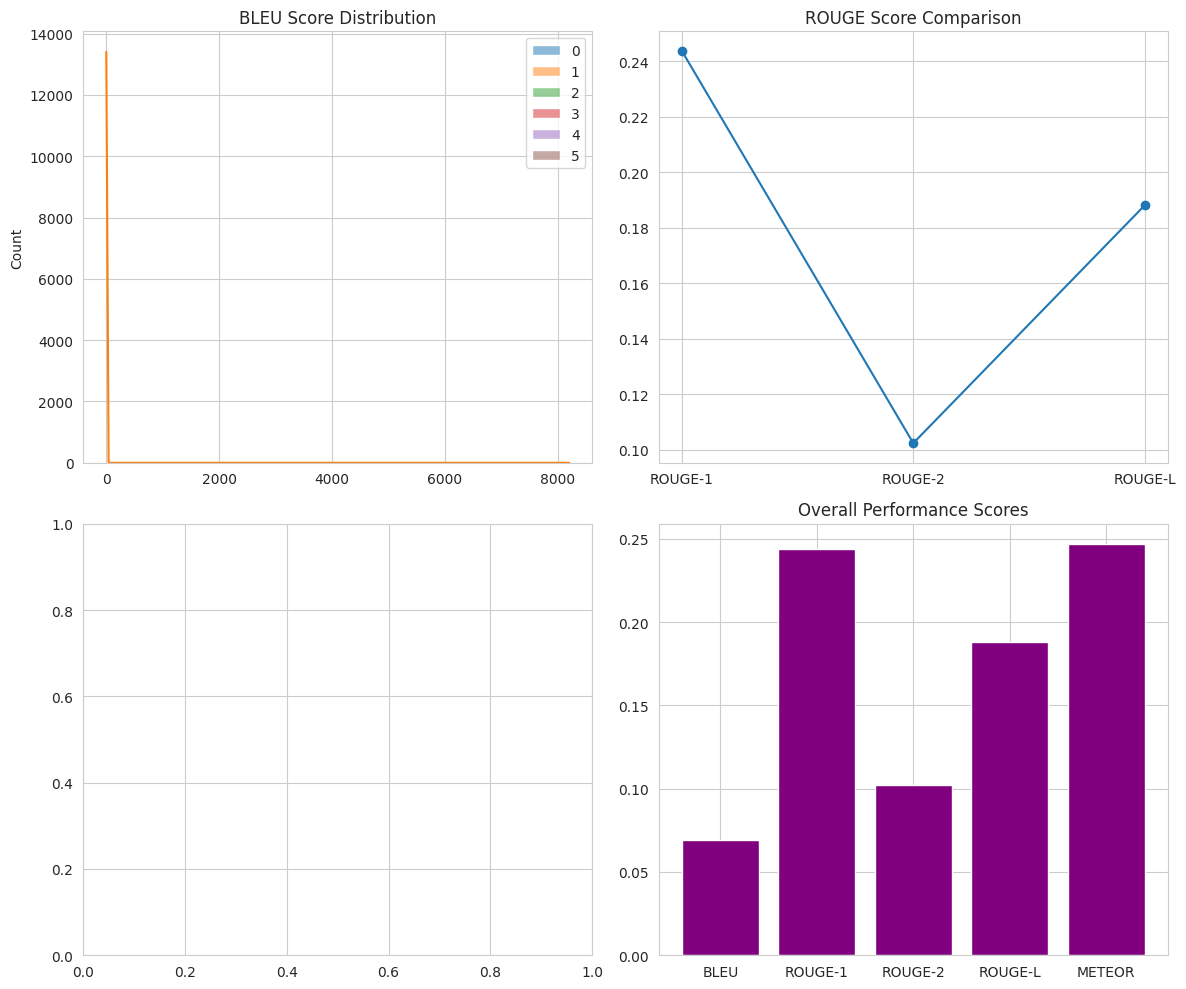

In [4]:
import torch
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, Dataset
from tqdm import tqdm

# Load validation dataset
data = load_dataset("tatsu-lab/alpaca", split="train")
data_df = data.to_pandas()
val_df = data_df[4000:4100]  # Use only 100 samples for validation

# Prepare the dataset
val_df["text"] = val_df[["input", "instruction", "output"]].apply(
    lambda x: f"###Human: {x['instruction']} {x['input']} ###Assistant: {x['output']}", axis=1
)
val_data = Dataset.from_pandas(val_df)

# Load trained model and tokenizer
model_path = "deep0210/mistral-rag"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

# Ensure PAD token is set
tokenizer.pad_token = tokenizer.eos_token

# Function to generate response
def generate_response(query):
    input_text = f"###Human: {query} ###Assistant:"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids.to(model.device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=128,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )

    response = tokenizer.decode(output[0], skip_special_tokens=True)
    response = response.replace(input_text, "").strip()
    return response

# Generate model responses
predictions = []
ground_truths = []
for example in tqdm(val_data, desc="Generating Responses"):
    query = example["instruction"] + " " + example["input"]
    pred = generate_response(query)
    predictions.append(pred)
    ground_truths.append(example["output"])

# Evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

bleu_score = bleu.compute(predictions=predictions, references=ground_truths)
rouge_scores = rouge.compute(predictions=predictions, references=ground_truths)
meteor_score = meteor.compute(predictions=predictions, references=ground_truths)

# Print results
print("BLEU Score:", bleu_score)
print("ROUGE Scores:", rouge_scores)
print("METEOR Score:", meteor_score)

# Visualization
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# BLEU Score Distribution
sns.histplot(list(bleu_score.values()), bins=10, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("BLEU Score Distribution")

# ROUGE Score Trends
axes[0, 1].plot([rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"]], marker='o')
axes[0, 1].set_xticks(range(3))
axes[0, 1].set_xticklabels(["ROUGE-1", "ROUGE-2", "ROUGE-L"])
axes[0, 1].set_title("ROUGE Score Comparison")

# Overall Performance
axes[1, 1].bar(["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "METEOR"],
               [bleu_score["bleu"], rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"], meteor_score["meteor"]],
               color="purple")
axes[1, 1].set_title("Overall Performance Scores")

plt.tight_layout()
plt.show()


BLEU Score: {'bleu': 0.06928429777785668, 'precisions': [0.21935169388252498, 0.08238776517020227, 0.04544319600499376, 0.028058645096056625], 'brevity_penalty': 1.0, 'length_ratio': 1.6096508434680268, 'translation_length': 8206, 'reference_length': 5098}
ROUGE Scores: {'rouge1': 0.24362874321669423, 'rouge2': 0.1024062946949908, 'rougeL': 0.188042129816505, 'rougeLsum': 0.19642825869261743}
METEOR Score: {'meteor': 0.246698204124745}

Your evaluation scores indicate the following:

BLEU Score (0.0693): Relatively low, suggesting that the model’s generated responses have significant lexical differences compared to the ground truth. This can happen due to differences in phrasing or verbosity.
ROUGE Scores:
ROUGE-1 (0.2436): Measures unigram (word-level) overlap—fairly reasonable.
ROUGE-2 (0.1024): Measures bigram overlap—indicating some alignment but not strong.
ROUGE-L (0.1880): Focuses on longest common subsequences—shows decent structure preservation.
METEOR Score (0.2467): This is an okay score, considering it evaluates semantic similarity rather than just word overlap.
Possible Next Steps:
Improve Response Consistency

Try tweaking temperature and top_p values in model.generate().
Example: Lowering temperature=0.5 can make responses more deterministic.
Use Post-Processing

Remove redundant words or hallucinated content from generated responses.
Example: If the model adds unnecessary phrases like "As an AI model...", filter them out.
Use a More Semantic Metric (BERTScore)

You might consider adding BERTScore, which captures meaning better than BLEU/ROUGE.